Miscilanous plots of spectra.

In [31]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

SDSS v X-shooter

In [3]:
sdss = fits.open('spectra/sdss/spec-4848-55955-0338.fits')

In [4]:
sdss.info()

Filename: spectra/sdss/spec-4848-55955-0338.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1                1 BinTableHDU     33   4641R x 8C   [E, E, E, J, J, E, E, E]   
  2                1 BinTableHDU    501   1R x 236C   [4A, 6A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 2A, D, D, 4A, 8A, E, E, E, J, E, 22A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 8A, 5A, E, E, E, E, E, E, E, E, J, E, E, J, J, 4A, 8A, E, 35E, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E

In [22]:
sdss[1].data.names

['FLUX', 'LOGLAM', 'IVAR', 'AND_MASK', 'OR_MASK', 'WDISP', 'SKY', 'MODEL']

In [6]:
data = sdss[1].data

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


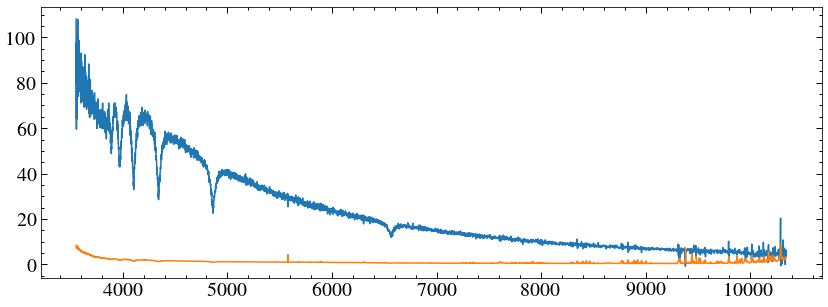

In [26]:
plt.plot(10**data['LOGLAM'], data['FLUX'])
plt.plot(10**data['LOGLAM'], (1/data['IVAR'])**0.5)


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


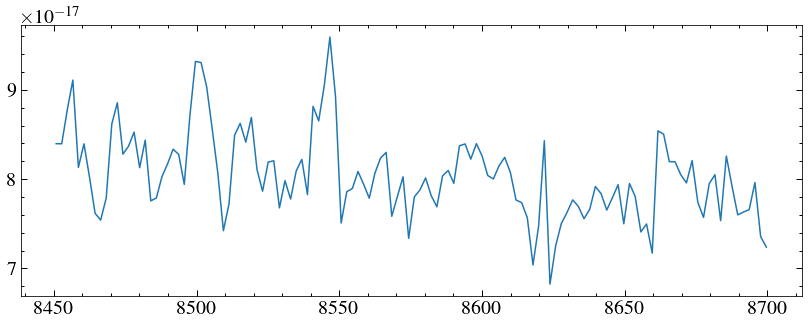

In [27]:
sw, sf, se = 10**data['LOGLAM'], data['FLUX']*1e-17, ((1/data['IVAR'])**0.5)*1e-17
mask = (sw > 8450) & (sw < 8700)
plt.plot(sw[mask], sf[mask])

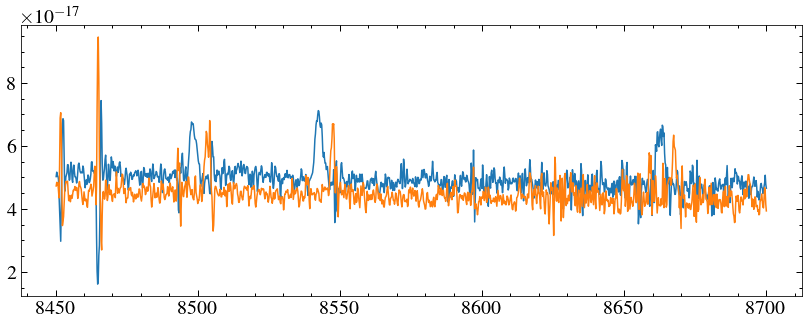

In [73]:
#xw, xf, xe = np.loadtxt('spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv', unpack=True, delimiter=',')
xw, xf, xe = np.loadtxt('stare_extractions/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_58189.08029528.csv', unpack=True, delimiter=',')
mask = (xw > 8450) & (xw < 8700)
plt.plot(xw[mask], xf[mask])

xw1, xf1, xe1 = np.loadtxt('stare_extractions/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_58168.274911677.csv', unpack=True, delimiter=',')
mask = (xw1 > 8450) & (xw1 < 8700)
plt.plot(xw1[mask], xf1[mask])

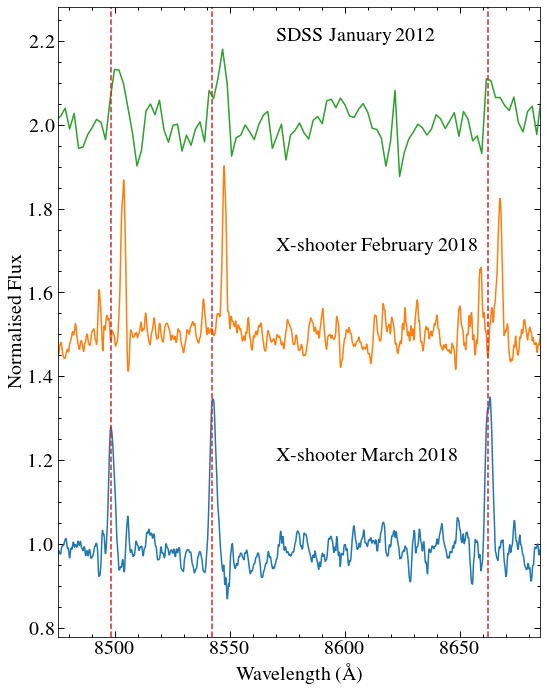

In [82]:
fitter = fitting.LevMarLSQFitter()


def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])


def make_plot_spec(w, f, e, mask1, mask2,smooth=10): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    if smooth > 0:
        nf = convolve(nf,Box1DKernel(smooth))
        ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne

lines = [8498.02,8542.09,8662.14]

#smask = (sw > 8450) & (sw < 8700)
#plt.plot(sw[smask], sf[smask])

#xmask = (xw > 8450) & (xw < 8700)
#plt.plot(xw[xmask], xf[xmask])
plt.figure(figsize=(8,10))
for i, w, f, e, smooth in zip([0,1, 2],[xw, xw1, sw], [xf, xf1, sf], [xe, xe1, se], [8, 8, 0]):
    slines = get_shifted_lines(8505, lines)
    mask1 = (w > 8460) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8470) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=smooth)
    #plt.step(w[2:-2],f[2:-2]+i*0.5, label = label, where='mid')
    plt.plot(w[2:-2],f[2:-2]+i*0.5)
#plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
[plt.axvline(line, ls='--', c='C3') for line in lines]
plt.xlim(8475, 8685)
plt.ylim(0.78, 2.28)
plt.annotate('X-shooter March 2018', (8570, 1.2), xycoords='data')
plt.annotate('SDSS January 2012', (8570, 2.2), xycoords='data')
plt.annotate('X-shooter February 2018', (8570, 1.7), xycoords='data')

plt.tight_layout()
plt.savefig('plots/sdss_v_xshooter.pdf')


In [25]:
sdss[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   32 /Number of bytes per row                         
NAXIS2  =                 4641 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    8 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [84]:
visfits = glob.glob('spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/*VIS*fits')
print(len(visfits))
for v in visfits:
    print(fits.getheader(v)['EXPTIME'])

33
600.0
400.0
400.0
300.0
400.0
400.0
400.0
400.0
600.0
400.0
400.0
400.0
400.0
400.0
400.0
400.0
400.0
400.0
400.0
400.0
300.0
400.0
400.0
600.0
300.0
300.0
400.0
400.0
400.0
400.0
400.0
600.0
400.0
